# Resnet Block

In [1]:
import torch
import ttnn
from ttnn.tracer import trace, visualize
from ttnn.model_preprocessing import preprocess_model_parameters, fold_batch_norm2d_into_conv2d

2025-07-09 07:04:12.795 | DEBUG    | ttnn:<module>:83 - Initial ttnn.CONFIG:
Config{cache_path=/home/ubuntu/.cache/ttnn,model_cache_path=/home/ubuntu/.cache/ttnn/models,tmp_dir=/tmp/ttnn,enable_model_cache=false,enable_fast_runtime_mode=true,throw_exception_on_fallback=false,enable_logging=false,enable_graph_report=false,enable_detailed_buffer_report=false,enable_detailed_tensor_report=false,enable_comparison_mode=false,comparison_mode_should_raise_exception=false,comparison_mode_pcc=0.9999,root_report_path=generated/ttnn/reports,report_name=std::nullopt,std::nullopt}


In [2]:
torch.manual_seed(0)
device_params = {"l1_small_size": 24576}
device = ttnn.CreateDevice(device_id=0, **device_params)

2025-07-09 07:04:12.845 | info     |   SiliconDriver | Opened PCI device 0; KMD version: 2.0.0; API: 2; IOMMU: disabled (pci_device.cpp:198)
2025-07-09 07:04:12.858 | info     |          Device | Opening user mode device driver (tt_cluster.cpp:190)
2025-07-09 07:04:12.858 | info     |   SiliconDriver | Opened PCI device 0; KMD version: 2.0.0; API: 2; IOMMU: disabled (pci_device.cpp:198)
2025-07-09 07:04:12.861 | info     |   SiliconDriver | Opened PCI device 0; KMD version: 2.0.0; API: 2; IOMMU: disabled (pci_device.cpp:198)
2025-07-09 07:04:12.864 | info     |   SiliconDriver | Harvesting mask for chip 0 is 0x40 (NOC0: 0x40, simulated harvesting mask: 0x0). (cluster.cpp:310)
2025-07-09 07:04:12.898 | info     |   SiliconDriver | Opened PCI device 0; KMD version: 2.0.0; API: 2; IOMMU: disabled (pci_device.cpp:198)
2025-07-09 07:04:12.906 | info     |   SiliconDriver | Opening local chip ids/pci ids: {0}/[0] and remote chip ids {} (cluster.cpp:171)
2025-07-09 07:04:12.906 | info     |  

## Torch Module (from torchvision)

In [3]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> torch.nn.Conv2d:
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


class TorchBasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample=None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer=None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## Create torch module and preprocess it to get ttnn parameters

In [4]:
torch_model = TorchBasicBlock(inplanes=64, planes=64, stride=1)
input_tensor = ttnn.rand((8, 64, 56, 56), dtype=ttnn.float32, device=device)
state_dict = torch_model.state_dict()


def create_custom_preprocessor(device):
    def custom_preprocessor(torch_model, name, ttnn_module_args):
        parameters = {}
        conv_weight_1, conv_bias_1 = fold_batch_norm2d_into_conv2d(torch_model.conv1, torch_model.bn1)
        parameters["conv1"] = {}
        parameters["conv2"] = {}
        parameters["conv1"]["weight"] = ttnn.from_torch(conv_weight_1, dtype=ttnn.bfloat16)
        parameters["conv1"]["bias"] = ttnn.from_torch(torch.reshape(conv_bias_1, (1, 1, 1, -1)), dtype=ttnn.bfloat16)
        conv_weight_2, conv_bias_2 = fold_batch_norm2d_into_conv2d(torch_model.conv2, torch_model.bn2)
        parameters["conv2"]["weight"] = ttnn.from_torch(conv_weight_2, dtype=ttnn.bfloat16)
        parameters["conv2"]["bias"] = ttnn.from_torch(torch.reshape(conv_bias_2, (1, 1, 1, -1)), dtype=ttnn.bfloat16)
        return parameters

    return custom_preprocessor


parameters = preprocess_model_parameters(
    initialize_model=lambda: torch_model, custom_preprocessor=create_custom_preprocessor(device), device=None
)


2025-07-09 07:04:14.646 | DEBUG    | ttnn:manage_config:91 - Set ttnn.CONFIG.enable_logging to False
2025-07-09 07:04:14.646 | DEBUG    | ttnn:manage_config:91 - Set ttnn.CONFIG.enable_comparison_mode to False
2025-07-09 07:04:14.646 | WARNING  | ttnn.model_preprocessing:from_torch:533 - ttnn: model cache can be enabled by passing model_name argument to preprocess_model[_parameters] and setting env variable TTNN_CONFIG_OVERRIDES='{"enable_model_cache": true}'
2025-07-09 07:04:14.647 | WARNING  | ttnn.model_preprocessing:_initialize_model_and_preprocess_parameters:483 - Putting the model in eval mode
2025-07-09 07:04:14.648 | DEBUG    | ttnn:manage_config:94 - Restored ttnn.CONFIG.enable_comparison_mode to False
2025-07-09 07:04:14.649 | DEBUG    | ttnn:manage_config:94 - Restored ttnn.CONFIG.enable_logging to False


## Display the parameters of the module

In [5]:
parameters

{
  conv1: {
    weight: ttnn.Tensor(shape=Shape([64, 64, 3, 3]), layout=Layout.ROW_MAJOR, dtype=DataType.BFLOAT16),
    bias: ttnn.Tensor(shape=Shape([1, 1, 1, 64]), layout=Layout.ROW_MAJOR, dtype=DataType.BFLOAT16)
  },
  conv2: {
    weight: ttnn.Tensor(shape=Shape([64, 64, 3, 3]), layout=Layout.ROW_MAJOR, dtype=DataType.BFLOAT16),
    bias: ttnn.Tensor(shape=Shape([1, 1, 1, 64]), layout=Layout.ROW_MAJOR, dtype=DataType.BFLOAT16)
  }
}

## Implement ttnn version of the module. Pass in the parameters into the constructor. 

In [6]:
class Conv:
    def __init__(
        self,
        conv_params,
        input_shape,
        parameters,
        *,
        act_block_h=None,
        reshard=False,
        deallocate=True,
        height_sharding=True,
        activation="",
        groups=1,
        dtype=ttnn.bfloat16,
    ) -> None:
        self.weights = parameters["weight"]
        if "bias" in parameters:
            self.bias = parameters["bias"]
        else:
            self.bias = None
        self.kernel_size = (self.weights.shape[2], self.weights.shape[3])
        self.conv_params = conv_params
        self.out_channels = self.weights.shape[0]
        self.act_block_h = act_block_h
        self.reshard = reshard
        self.deallocate = deallocate
        self.activation = activation
        self.groups = groups
        self.dtype = dtype
        self.shard_layout = (
            ttnn.TensorMemoryLayout.HEIGHT_SHARDED if height_sharding else ttnn.TensorMemoryLayout.BLOCK_SHARDED
        )
        self.input_shape = input_shape

    def __call__(self, device, input_tensor):

        conv_config = ttnn.Conv2dConfig(
            weights_dtype=ttnn.bfloat16,
            # math_fidelity=ttnn.MathFidelity.LoFi,
            activation=self.activation,
            shard_layout=self.shard_layout,
            # fp32_dest_acc_enabled=False,
            # packer_l1_accum_enabled=False,
            deallocate_activation=self.deallocate,
        )
        if self.act_block_h is not None:
            conv_config.act_block_h_override = self.act_block_h

        [output_tensor, (_out_height, _out_width), (self.weights, self.bias)] = ttnn.conv2d(
            input_tensor=input_tensor,
            weight_tensor=self.weights,
            bias_tensor=self.bias,
            in_channels=self.input_shape[3],
            out_channels=self.out_channels,
            device=device,
            kernel_size=self.kernel_size,
            stride=(self.conv_params[0], self.conv_params[1]),
            padding=(self.conv_params[2], self.conv_params[3]),
            batch_size=self.input_shape[0],
            input_height=self.input_shape[1],
            input_width=self.input_shape[2],
            conv_config=conv_config,
            groups=self.groups,
            return_output_dim=True,
            return_weights_and_bias=True,
            dtype=self.dtype,
        )

        return output_tensor


class TTNNBasicBlock:

    def __init__(
        self,
        parameters,
    ) -> None:
        self.conv1 = Conv([1, 1, 1, 1], [8, 56, 56, 64], parameters=parameters["conv1"])
        self.conv2 = Conv([1, 1, 1, 1], [8, 56, 56, 64], parameters=parameters["conv2"])
        if "downsample" in parameters:
            self.downsample = parameters.downsample
        else:
            self.downsample = None

    def __call__(self, x, device):
        identity = x

        out = self.conv1(device, x)
        out = ttnn.relu(out)
        out = self.conv2(device, out)

        if self.downsample is not None:
            identity = self.downsample(x)

        identity = ttnn.reshape(identity, out.shape)

        identity = ttnn.to_memory_config(
            identity,
            memory_config=ttnn.get_memory_config(out),
            dtype=ttnn.bfloat16,
        )
        out = ttnn.add(out, identity, memory_config=ttnn.get_memory_config(out))
        out = ttnn.relu(out)

        return out

def run_model(model, input_tensor, device):
    input_tensor = ttnn.permute(input_tensor, (0, 2, 3, 1))
    input_tensor = ttnn.to_layout(input_tensor, layout=ttnn.TILE_LAYOUT, dtype=ttnn.bfloat16)

    output_tensor = model(input_tensor, device)
    output_tensor = ttnn.to_memory_config(output_tensor, ttnn.DRAM_MEMORY_CONFIG)
    output_tensor = ttnn.permute(output_tensor, (0, 3, 1, 2))
    output_tensor = ttnn.reshape(output_tensor, input_tensor.shape)
    output_tensor = ttnn.from_device(output_tensor)
    output_tensor = ttnn.to_torch(output_tensor)
    return output_tensor

## Run ttnn module and display the traced graph

2025-07-09 07:04:14.788 | warning  |              Op | ttnn::to_layout: dtype is specified but the tensor is already in the requested layout! So, the dtype won't be changed! (to_layout_op.cpp:53)


2025-07-09 07:04:16.019 | INFO     | ttnn.graph:_visualize:154 - Graph visualization saved to "/tmp/006_traced_graph.svg"


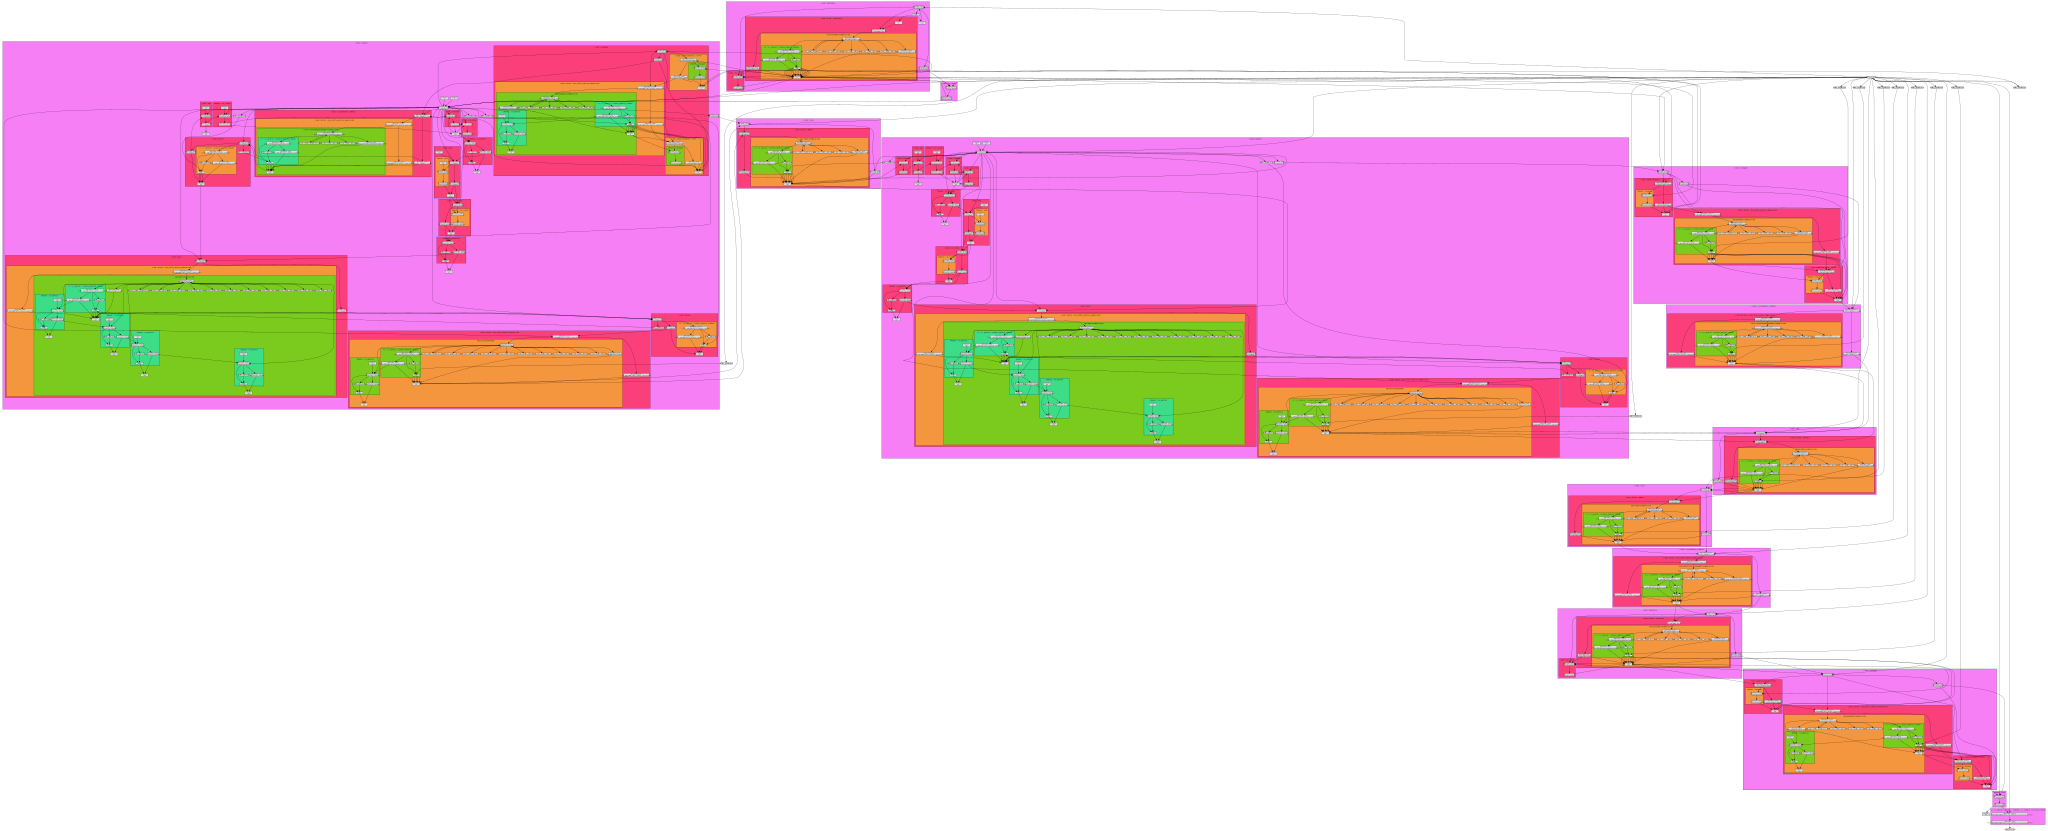

In [7]:
ttnn_model = TTNNBasicBlock(parameters)
ttnn.graph.begin_graph_capture(ttnn.graph.RunMode.NO_DISPATCH)
output_tensor = run_model(ttnn_model, input_tensor, device=device)
captured_graph = ttnn.graph.end_graph_capture()
ttnn.graph.visualize(captured_graph, file_name="/tmp/006_traced_graph.svg")

In [8]:
ttnn.close_device(device)